In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from scikeras.wrappers import KerasRegressor



In [3]:
# ボストンの住宅価格データセットをロード
# data_urlにはKaggleなどからダウンロードしたデータセットのパスを指定
data_url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
data = pd.read_csv(data_url)

In [4]:
# 値段の中央値を目的変数に設定
X = data.drop('medv',axis=1)
Y = data.medv

In [5]:
# データセットの分割
X_train, X_test, y_train, y_test = train_test_split(X,Y,train_size=0.8)

In [6]:
# 正規化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
def create_model(optimizer='adam',activation='relu',neurons=64):
    model = Sequential()
    model.add(Dense(neurons,activation=activation))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(1,activation='linear'))
    model.compile(optimizer=optimizer,loss='mse')
    return model 

In [28]:
# KerasClassifierでモデルをラップする
model = KerasRegressor(build_fn=create_model, verbose=0,neurons=64,activation='relu')

In [29]:
# KerasClassifierでモデルをラップする
model = KerasRegressor(build_fn=create_model, verbose=0,neurons=64,optimizer='adam')

In [30]:
# ハイパーパラメータの探索範囲を設定
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'neurons': [128, 64, 32]
}

In [34]:
# GridSearchCVで最適なパラメータを探索
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train,y_train)

ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_101' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_102' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_103' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_104' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_105' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_106' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_107' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_108' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_109' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_110' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_111' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_112' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_113' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_114' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_115' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_116' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_117' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_118' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_119' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_120' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_121' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_122' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_123' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_124' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_125' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_126' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_127' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_128' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_129' has no defined outputs yet.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\scikeras\wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
                                       ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ryuuu\OneDrive\ドキュメント\python_samples\code\myenv\Lib\site-packages\keras\src\models\sequential.py", line 292, in outputs
    raise ValueError(
ValueError: Sequential model 'sequential_130' has no defined outputs yet.


In [42]:
# ModelCheckpointコールバックの設定
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
model.fit(X_train,y_train,epochs=100,validation_split=0.2,callbacks=[checkpoint])

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.9223 - val_loss: 14.5643
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.5369 - val_loss: 14.8077
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.9872 - val_loss: 14.8950
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4799 - val_loss: 15.8422
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.8115 - val_loss: 15.3224
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.0350 - val_loss: 15.0565
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.6283 - val_loss: 15.3112
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.0091 - val_loss: 15.2170
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.0303 - val_loss: 15.3976
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.0868 - val_loss: 15.3373
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7954 - val_loss: 15.2711
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

In [43]:
best_model = load_model('best_model.keras')
predictions = best_model.predict(X_test)

In [29]:
for i in range(len(predictions)):
    print(f"predictions:{predictions[i,0]:.1f} | actual:{y_test.iloc[i]}")

predictions:13.4 | actual:17.2
predictions:30.8 | actual:30.8
predictions:25.0 | actual:25.0
predictions:15.2 | actual:11.9
predictions:13.9 | actual:13.8
predictions:15.2 | actual:11.7
predictions:55.0 | actual:50.0
predictions:20.8 | actual:23.1
predictions:16.1 | actual:16.0
predictions:34.2 | actual:32.4
predictions:18.6 | actual:19.9
predictions:10.6 | actual:9.6
predictions:15.6 | actual:17.6
predictions:12.1 | actual:10.9
predictions:19.6 | actual:19.5
predictions:27.2 | actual:22.5
predictions:48.5 | actual:50.0
predictions:31.9 | actual:31.6
predictions:29.5 | actual:26.7
predictions:31.6 | actual:23.6
predictions:19.6 | actual:22.0
predictions:22.9 | actual:23.8
predictions:51.0 | actual:50.0
predictions:15.2 | actual:8.5
predictions:38.8 | actual:50.0
predictions:10.5 | actual:7.5
predictions:15.5 | actual:15.2
predictions:16.6 | actual:13.1
predictions:12.4 | actual:13.5
predictions:12.9 | actual:8.8
predictions:16.8 | actual:16.7
predictions:26.2 | actual:25.2
predictions:

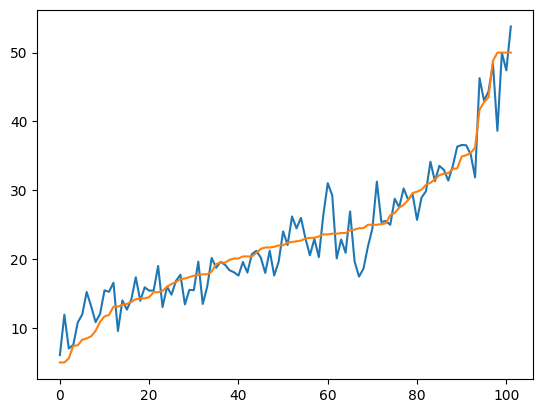

In [45]:
plt.plot(predictions[:,0][np.argsort(y_test.values)])
plt.plot(np.sort(y_test.values))

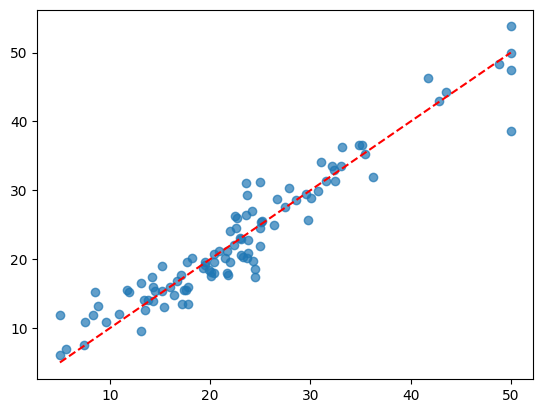

In [46]:
plt.scatter(y_test, predictions, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')